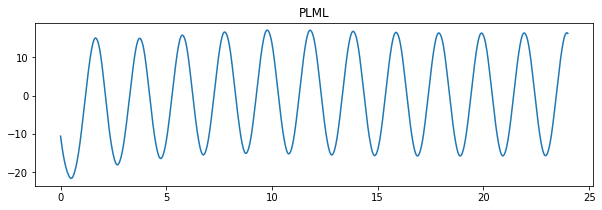

In [47]:
from util.neuron_metadata import *
from util.plot_util import *
import numpy as np
import pandas as pd
from neural_model import NeuralModel
neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json('data/chem.json')

model = NeuralModel(neuron_metadata_collection)
model.seed = 0
model.set_current_injection("AVBL", 2.3)
model.set_current_injection("AVBR", 2.3)
model.set_current_injection("PLML", 1.4)
model.set_current_injection("PLMR", 1.4)
model.init()
(v_mat, s_mat, v_normalized_mat) = model.run(2700)
# The oscillatory dynamic doesn't stabilize until about dt*300 onwards.
# Also, interactome analysis is done after the first 50 timesteps.
fwd_dynamics = v_normalized_mat[300:,:]

# Plot one neuron just to show the oscillation
plot_saved_dynamics(['PLML'], fwd_dynamics, neuron_metadata_collection)

In [48]:
# Get all the motor neurons
motor_neurons = []
for id in range(neuron_metadata_collection.get_size()):
    if neuron_metadata_collection.get_metadata(id).neuron_type == NeuronType.MOTOR:
        motor_neurons.append(id)
        
# Worm atlas says 113: "A total of 113 of the 302 C. elegans neurons belong to the motor neuron category"
# But, we get 109 motor neurons. Close enough.
# Let's extract out just the motor neurons' time series.
fwd_motor_dynamics = fwd_dynamics[:,motor_neurons]
fwd_motor_dynamics.shape

(2400, 109)

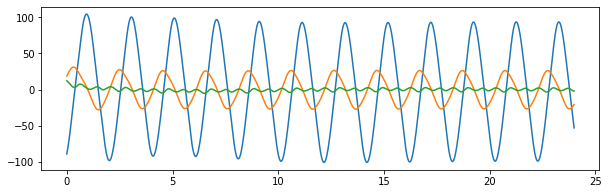

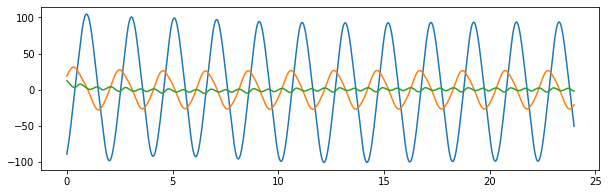

In [49]:
from sklearn.decomposition import PCA
# Perform mean-centering before PCA
X = fwd_motor_dynamics - fwd_motor_dynamics.mean(axis= 0)

pca = PCA(n_components=4)
projected_X = pca.fit_transform(X)
num_timesteps = fwd_motor_dynamics.shape[0]
times = np.arange(0, num_timesteps * 0.01 , 0.01)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(times, projected_X[:,0])
ax.plot(times, projected_X[:,1])
ax.plot(times, projected_X[:,2])

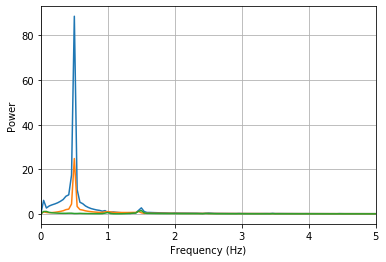

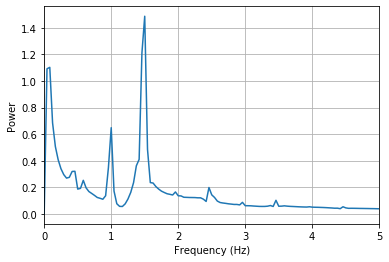

In [17]:
plot_principal_component_fft(n_components=3, projected=projected_X, t=0.01)

# plot just 3rd
projected = np.row_stack(projected_X[:, 2])
plot_principal_component_fft(1, projected, 0.01)

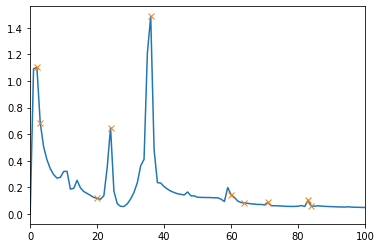

In [60]:
import scipy.signal as signal

projected = np.row_stack(projected_X[:, 2])

# find peaks of fft for computing pc oscillatory period
t = 0.01
N = len(projected)
pc_fft = fft(projected[:,0])
pc_fft_freq = np.linspace(0., 1./(2. * t), N//2)

widths = np.arange(1,10)
pc_fft_rs = np.reshape(pc_fft, (N))
pc_fft_rs = 2.0/N * np.abs(pc_fft_rs[0:N//2])
peaks = signal.find_peaks_cwt(pc_fft_rs, widths, min_length=1)

# plot
fig, ax = plt.subplots()
ax.set_xlim(0, 100)
ax.plot(pc_fft_rs)
ax.plot(peaks, pc_fft_rs[peaks], "x")

Text(0.5, 0, 'Time (s)')

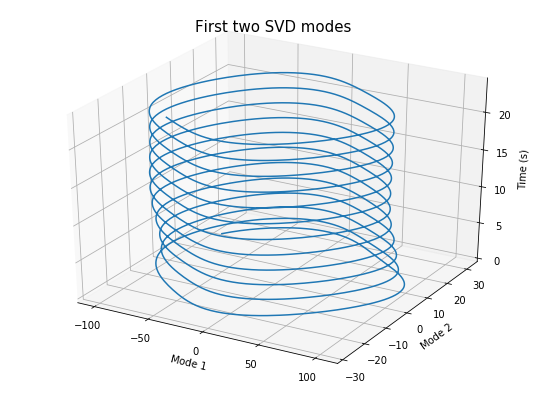

In [75]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(21,7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(projected_X[:,0], projected_X[:,1], times)

ax.set_title("First two SVD modes", fontsize=15)
ax.set_xlabel('Mode 1', fontsize=10)
ax.set_ylabel('Mode 2', fontsize=10)
ax.set_zlabel('Time (s)', fontsize=10)

In [52]:
# Confirm that pca.singular_values really are singular values.
# https://towardsdatascience.com/pca-and-svd-explained-with-numpy-5d13b0d2a4d8
# Yep, they match. pca.singular_values really are the singular values from SVDs, NOT the PC eigenvalues.
n = X.shape[0]
C = np.dot(X.T, X) / (n-1)
eigen_vals, eigen_vecs = np.linalg.eig(C)
eigen_vals[0]
(pca.singular_values_ ** 2 / (n-1)) [0:3]

array([4361.64928494,  344.15058727,    5.02451987])

In [53]:
eigen_vals[0:3]

array([4361.64928494,  344.15058727,    5.02451987])

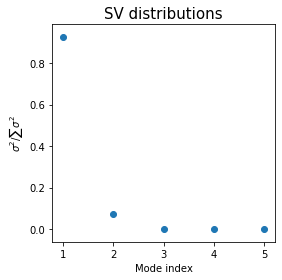

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
sigma_squared = np.square(pca.singular_values_)
sigma_squared_normed = sigma_squared / sum(sigma_squared)

ax.set_title("SV distributions", fontsize=15)
x_labels = list(range(1, 6))
ax.scatter(x_labels, sigma_squared_normed[:5])
ax.set_xlabel('Mode index', fontsize=10)
ax.set_ylabel('$\sigma^2 / \sum\sigma^2$', fontsize=10)
_ = ax.set_xticks(x_labels)

In [58]:
sigma_squared_normed[0]

0.9246342048836335

In [59]:
sigma_squared_normed[1]

0.07295712787435163